In [ ]:
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.cm as cm
!pip install arch
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings


In [ ]:


%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4

In [ ]:
def hurst(ts):
    lags = range(2, 100)
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = polyfit(log(lags), log(tau), 1)
    return poly[0]*2.0

In [ ]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
amzn = pd.read_csv('/content/drive/MyDrive/Option_Pricing/Amazon Stock Data 5years.csv')

In [ ]:
start = pd.Timestamp('2024-08-30')
end = pd.Timestamp('2024-12-06')

amzn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        1258 non-null   object
 1   Close/Last  1258 non-null   object
 2   Volume      1258 non-null   int64 
 3   Open        1258 non-null   object
 4   High        1258 non-null   object
 5   Low         1258 non-null   object
dtypes: int64(1), object(5)
memory usage: 59.1+ KB


In [ ]:
amzn.head()

,Date,Close/Last,Volume,Open,High,Low
0,12/06/2024,$227.03,44178070,$220.75,$227.15,$220.60
1,12/05/2024,$220.55,41140220,$218.03,$222.15,$217.30
2,12/04/2024,$218.16,48745720,$215.96,$220.00,$215.75
3,12/03/2024,$213.44,32214830,$210.31,$214.02,$209.65
4,12/02/2024,$210.71,39523190,$209.96,$212.99,$209.5101


In [ ]:
amzn.rename(columns={'Close/Last': 'Close'}, inplace=True)

In [ ]:

amzn['Close'] = (
    amzn['Close']
        .astype(str)
        .str.strip()
        .replace('', np.nan)              # turn empty strings into NaN
        .str.replace(',', '', regex=False)
        .str.replace('$', '', regex=False)
)

amzn['Close'] = pd.to_numeric(amzn['Close'], errors='coerce')

# (optional) drop rows where Close is missing
amzn = amzn.dropna(subset=['Close'])


In [ ]:

amzn['Return'] = 100 * (amzn['Close'].pct_change())
amzn['Log_Return'] = np.log(amzn['Close']).diff().mul(100)

In [ ]:
#amzn['Close'] = amzn['Close'].astype(str)
#amzn['Close'] = amzn['Close'].str.replace(r'[^0-9.]', '', regex=True).astype(float)

In [ ]:
print(amzn['Close'].unique())

[227.03   220.55   218.16   ...  87.436   86.9605  87.4755]


In [ ]:
amzn = amzn.dropna(subset=['Close'])

In [ ]:
amzn['Return'] = 100 * (amzn['Close'].pct_change())
amzn['Log_Return'] = np.log(amzn['Close']).diff().mul(100)
amzn = amzn.dropna()

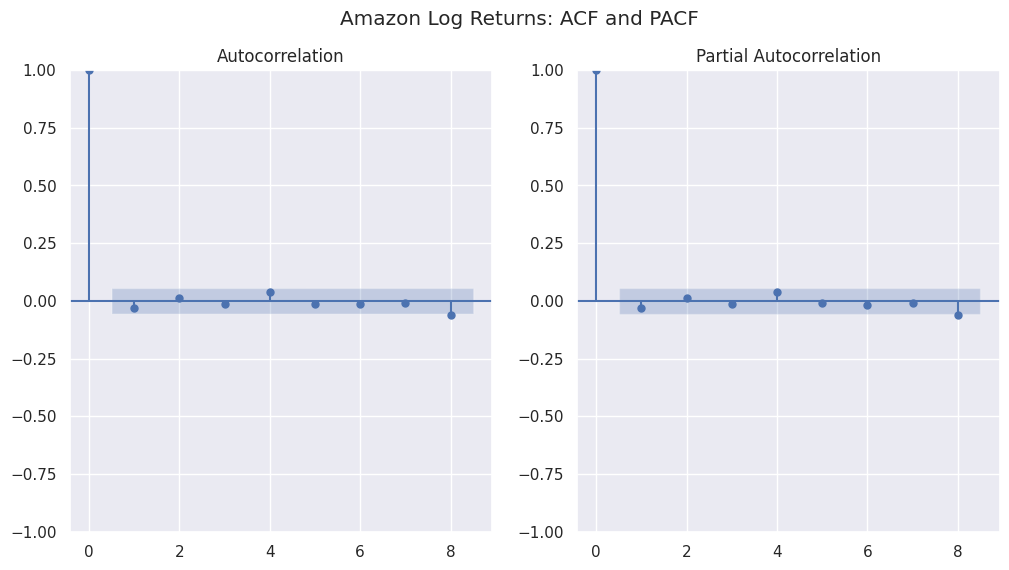

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
max_lags = min(8, len(amzn['Log_Return']) - 1)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(amzn['Log_Return'], lags=max_lags, ax=axes[0])
plot_pacf(amzn['Log_Return'], lags=max_lags, ax=axes[1])
plt.suptitle('Amazon Log Returns: ACF and PACF')
plt.show()


In [ ]:
print(len(amzn['Log_Return'].sub(amzn['Log_Return'].mean()).pow(2)))

1257


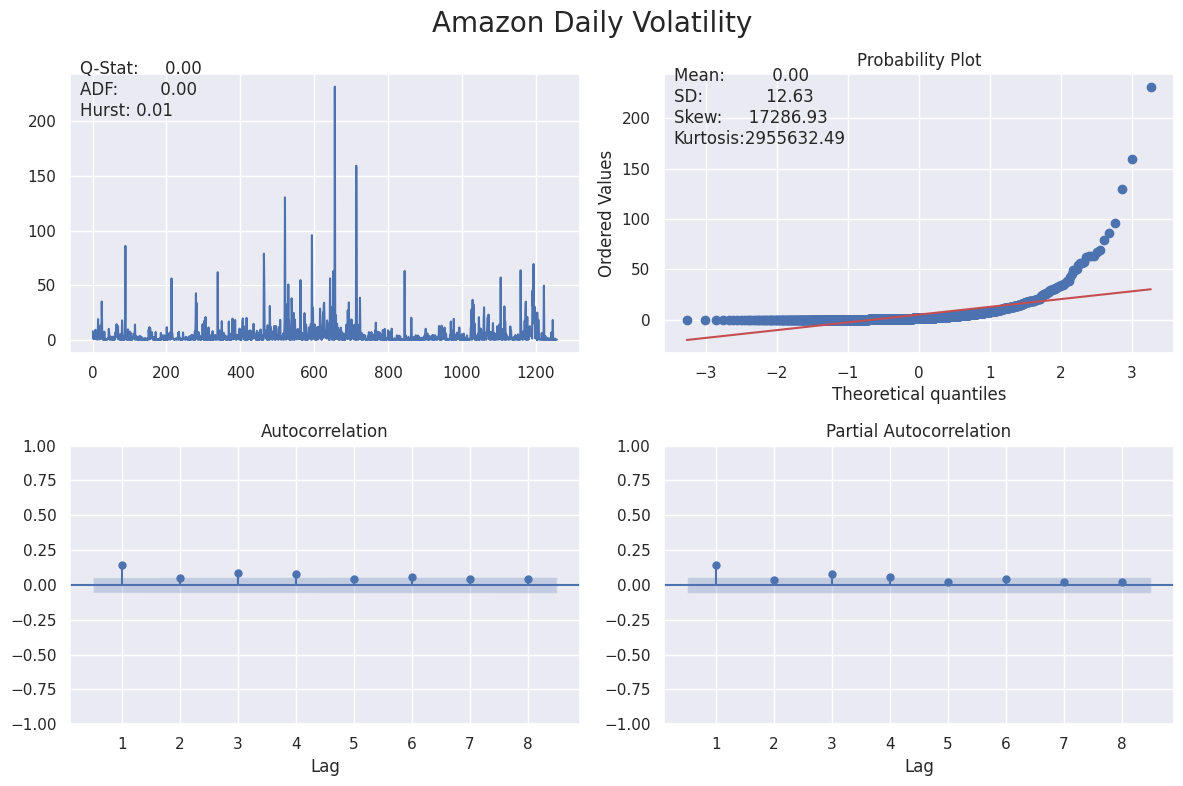

In [ ]:
valid_lags = min(8, len(amzn['Log_Return']) - 1)
plot_correlogram(amzn['Log_Return'].sub(amzn['Log_Return'].mean()).pow(2), lags=valid_lags, title='Amazon Daily Volatility')

In [ ]:
std_daily = amzn['Return'].std()
print(f'Daily volatility: {round(std_daily,2)}%')

std_monthly = np.sqrt(21) * std_daily
print(f'\nMonthly volatility: {round(std_monthly,2)}%')

std_quarterly = np.sqrt(4 * 21) * std_daily
print(f'\nQuarterly volatility: {round(std_quarterly,2)}%')

std_annual = np.sqrt(252) * std_daily
print(f'\nAnnual volatility: {round(std_annual,2)}%')

Daily volatility: 2.27%

Monthly volatility: 10.39%

Quarterly volatility: 20.77%

Annual volatility: 35.98%


In [ ]:
def simulate_GARCH(n, omega, alpha, beta = 0):
    np.random.seed(4)
    white_noise = np.random.normal(size = n)
    resid = np.zeros_like(white_noise)
    variance = np.zeros_like(white_noise)
    for t in range(1, n):
        variance[t] = omega + alpha * resid[t-1]**2 + beta * variance[t-1]
        resid[t] = np.sqrt(variance[t]) * white_noise[t]

    return resid, variance

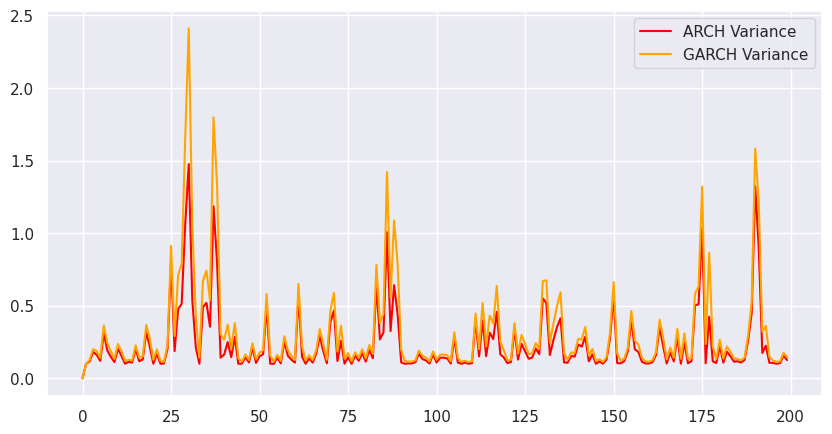

In [ ]:
arch_resid, arch_variance = simulate_GARCH(n= 200,
                                           omega = 0.1, alpha = 0.7)
garch_resid, garch_variance = simulate_GARCH(n= 200,
                                             omega = 0.1, alpha = 0.7,
                                             beta = 0.1)
plt.figure(figsize=(10,5))
plt.plot(arch_variance, color = 'red', label = 'ARCH Variance')
plt.plot(garch_variance, color = 'orange', label = 'GARCH Variance')
plt.legend()
plt.show()

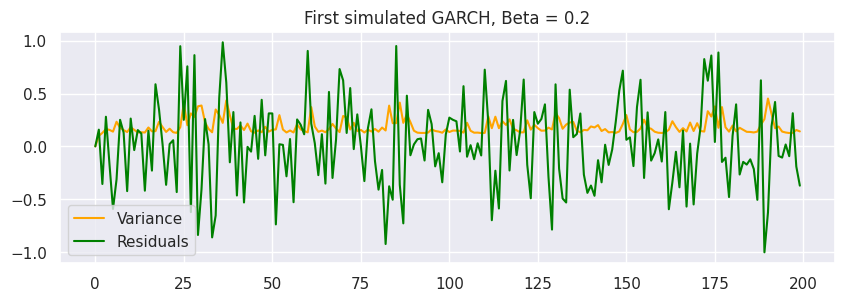

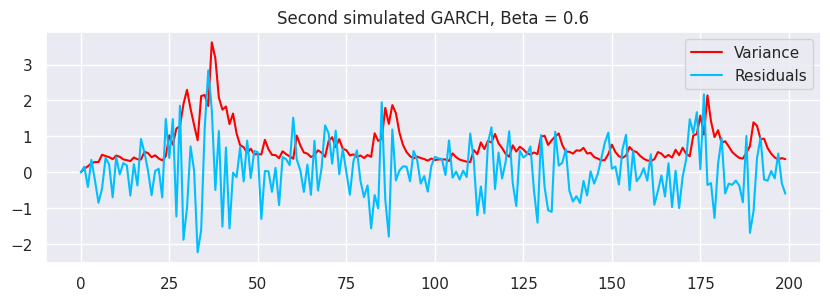

In [ ]:
plt.figure(figsize=(10,3))
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, alpha = 0.3, beta = 0.2)
plt.plot(sim_variance, color = 'orange', label = 'Variance')
plt.plot(sim_resid, color = 'green', label = 'Residuals')
plt.title('First simulated GARCH, Beta = 0.2')
plt.legend(loc='best')
plt.show()
plt.figure(figsize=(10,3))
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, alpha = 0.3, beta = 0.6)
plt.plot(sim_variance, color = 'red', label = 'Variance')
plt.plot(sim_resid, color = 'deepskyblue', label = 'Residuals')
plt.title('Second simulated GARCH, Beta = 0.6')
plt.legend(loc='best')
plt.show()

In [ ]:
print(amzn.columns)


Index(['Date', 'Close', 'Volume', 'Open', 'High', 'Low', 'Return',
       'Log_Return'],
      dtype='object')


In [ ]:
basic_gm = arch_model(amzn['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
gm_result = basic_gm.fit(update_freq = 4)

Iteration:      4,   Func. Count:     31,   Neg. LLF: 2952.1124045245647
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2746.3471699183983
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2746.347154115844
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 11


In [ ]:
print(gm_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2746.35
Distribution:                  Normal   AIC:                           5500.69
Method:            Maximum Likelihood   BIC:                           5521.24
                                        No. Observations:                 1257
Date:                Sat, Nov 15 2025   Df Residuals:                     1256
Time:                        15:21:50   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.1055  5.843e-02     -1.806  7.094e-02 [ -0.220,

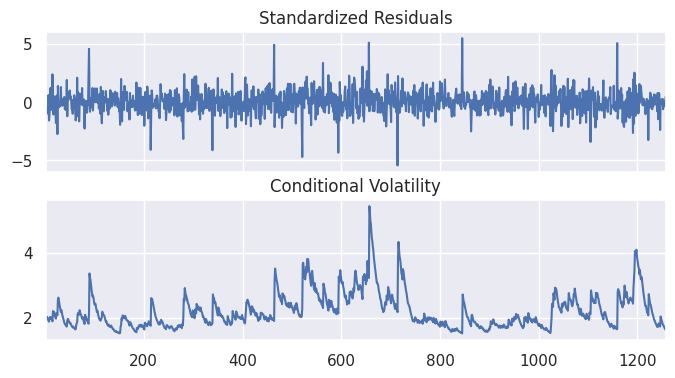

In [ ]:
gm_result.plot()
plt.show()

In [ ]:
gm_forecast = gm_result.forecast(horizon = 5)
print(gm_forecast.variance[-1:])

           h.1       h.2       h.3       h.4       h.5
1257  2.585713  2.693585  2.797053  2.896297  2.991489


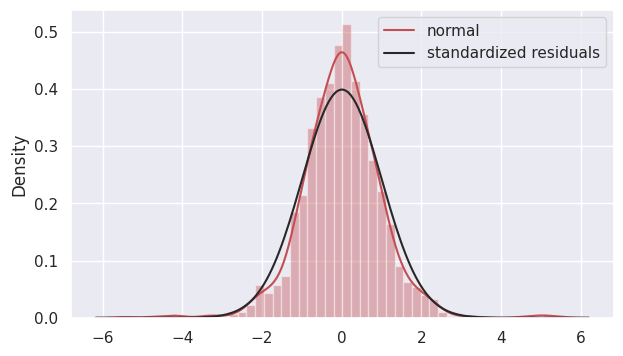

In [ ]:
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility
gm_std_resid = gm_resid /gm_std
plt.figure(figsize=(7,4))
sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('normal', 'standardized residuals'))
plt.show()